## Advanced Machine Learning Final Project
### Group 2
* Jake Machulcz
* Danielle Stealy
* Bridget Liesman
* Erich Haley

In [1]:
#Import libraries for gathering, cleaning, and exploring data and for model creation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from wordcloud import WordCloud
import re
import random
from sklearn.metrics import (
    confusion_matrix, 
    recall_score, 
    precision_score, 
    roc_auc_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding, TextVectorization, Dropout, Input, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC

#Ensure results are reproducible
SEED = 1842
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

## Problem Definition

Our team works under Brian Naughton, the dual CEO and head of Data Science, at _Everything at Once_, the explosive app that is used by top execs and business school students alike. This app distills the news into brief, digestable snippets, alowing busy professionals to quickly understand the day's events without spending hours pouring over newspapers. The app launched in the summer and is already on both Apple and Samsung's top 10 most downloaded apps of 2025.

Now the team is moving to the next phase and plans to provide filtering by topic to our customers to provide even more personalized news articles. This is a new feature and we are a small team so we want to focus on the biggest impact first. Through market study, we have found that our largest user demographics are business executives and university researchers. Therefore, our first round of modeling will classify articles focusing on Business vs. those focusing on Science/Technology. If we can convince Brian of our models' abilities, we can release the feature to the public and dedicate resources toward classifying other categories of interest for our users.

For our analysis, we will focus on optimizing accuracy. The main reason for this is that we do not have an obviously positive or negative outcome. Misclassifying business articles is not significantly better or worse than misclassifying science articles. If our EDA shows high class imbalance, we may consider a metric like an F1 value, but currently, we plan to focus on accuracy.

## Load the Data

We are using the AG News Subset to gather article descriptions

In [2]:
# Code provided by project description to obtain dataset
train_data, test_data = tfds.load(
  'ag_news_subset',
  split = ['train', 'test'],
  batch_size = -1,
  as_supervised=True #Added this line to ensure the code worked
)

# Split the text and labels apart
train_reviews, train_labels = tfds.as_numpy(train_data)
test_reviews, test_labels = tfds.as_numpy(test_data)

#view example of each dataset
print(train_reviews[:3])
print(test_reviews[:3])

2025-12-07 13:42:29.181179: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


[b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
 b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
 b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.']
[b' CHARLOTTE, N.C. (Sports Network) - Carolina Panthers  running back Stephen Davis will miss the remainder of the  season after being placed on injured reserve Saturday.'
 b' PRESENTACION, Philippines (Reuters) - Philippine communist  rebels freed Wednesday two soldiers they had held as "prisoners  of war" for more than five months, saying they wanted to  rebuild confidence in peace talks with the governmen

## Clean the Data

The data requires some cleaning before classification to ensure our models are not biased by noise. To make this process simple, we'll first create some cleaning functions and then apply each function to our testing and training sets to avoid data leakage.

In [3]:
#Create cleaning functions
#Clean a single text string
def clean_text_string(s: str) -> str:
    # Replace HTML-like artifacts (#39; -> ')
    s = s.replace("#39;", "'")
    
    # Lowercase
    s = s.lower()
    
    # Keep letters, numbers, punctuation (. ? ! ')
    s = re.sub(r"[^a-z0-9.?!' ]+", " ", s)
    
    # Strip leading/trailing apostrophes
    s = s.strip("'")
    
    # Fix possessives: " john 's " -> "john's"
    s = re.sub(r"\s+'", "'", s)
    
    return s

#Clean an array of byte strings or normal strings
def clean_text_array(arr):
    cleaned = []
    for t in arr:
        # If bytes, decode to string
        if isinstance(t, bytes):
            t = t.decode("utf-8", errors="ignore")
        cleaned.append(clean_text_string(t))
    return np.array(cleaned, dtype=object)

In [4]:
#Apply functions to training and testing sets
train_reviews_clean = clean_text_array(train_reviews)
test_reviews_clean  = clean_text_array(test_reviews)

#View example of data
print(train_reviews_clean[:3])
print(test_reviews_clean[:3])

["amd's new dual core opteron chip is designed mainly for corporate computing applications  including databases  web services  and financial transactions."
 'reuters   major league baseball monday announced a decision on the appeal filed by chicago cubs pitcher kerry wood regarding a suspension stemming from an incident earlier this season.'
 "president bush's  quot revenue neutral quot  tax reform needs losers to balance its winners  and people claiming the federal deduction for state and local taxes may be in administration planners' sights  news reports say."]
[' charlotte  n.c.  sports network    carolina panthers  running back stephen davis will miss the remainder of the  season after being placed on injured reserve saturday.'
 ' presentacion  philippines  reuters    philippine communist  rebels freed wednesday two soldiers they had held as  prisoners  of war  for more than five months  saying they wanted to  rebuild confidence in peace talks with the government.'
 "san francisco 

Now that the text strings are clean, we will filter each dataset only for categories we are interested in - Business and Science/Tech.

In [5]:
#Categories of interest
Business = 2
SciTech  = 3

#get indices of the data we want to keep
mask_train = np.isin(train_labels, [Business, SciTech])
mask_test  = np.isin(test_labels,  [Business, SciTech])

#filter the cleaned data for the indices we are interested in
x_train_filtered = train_reviews_clean[mask_train]
y_train_filtered = train_labels[mask_train]
x_test_filtered  = test_reviews_clean[mask_test]
y_test_filtered  = test_labels[mask_test]

To make our analysis simple, we will convert the labels to binary 0 and 1 instead of the currently used 2 and 3, which is left over from the larger, un-filtered dataset.

In [6]:
#Converting our labels to binary
label_map = {Business: 0, SciTech: 1}

#Apply new labels to our target datasets
y_train_bin = np.vectorize(label_map.get)(y_train_filtered)
y_test_bin  = np.vectorize(label_map.get)(y_test_filtered)

#Confirming our values are now 0 and 1
print("Unique training labels:", np.unique(y_train_bin))
print("Unique test labels:", np.unique(y_test_bin))

Unique training labels: [0 1]
Unique test labels: [0 1]


In [7]:
# Creating our Train/Validation Split
x_train, x_valid, y_train, y_valid = \
    train_test_split(x_train_filtered,  y_train_bin, test_size=0.3, stratify=y_train_bin, random_state=SEED)

#Final train, validation, and test set sizes
print('Training Sets:', x_train.shape, y_train.shape)
print('Validation Sets:', x_valid.shape, y_valid.shape)
print('Test Sets:', x_test_filtered.shape, y_test_filtered.shape)

Training Sets: (42000,) (42000,)
Validation Sets: (18000,) (18000,)
Test Sets: (3800,) (3800,)


## EDA

In this section, we perform Exploratory Data Analysis (EDA) on the filtered AG News dataset to understand the characteristics of our categories of interest. We have already done some initial cleaning to focus on our categories of interest: 
* Business (label = 0)
* Sci/Tech (label = 1)

Additionally, per data science best-practices, our dataset has been split into testing, training, and validation sets and we will focus our EDA on the training set to avoid data leakage. 

### Class Balance

In order to ensure we do not have a majority class that dominates our models' predictions, we need to ensure there is balance in the two classes.

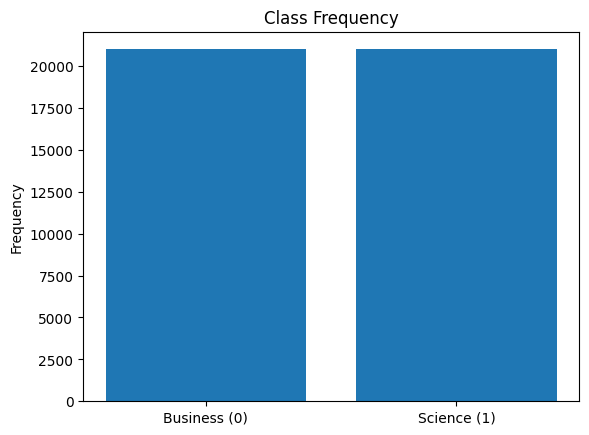

Business Count: 21000
Science Count: 21000


In [8]:
#Find counts for each class
n_bus = len(y_train) - sum(y_train)
n_sci = sum(y_train)

#Plot the counts of each class
plt.bar(['Business (0)', 'Science (1)'], [n_bus, n_sci])
plt.ylabel('Frequency')
plt.title('Class Frequency')
plt.show()

print('Business Count:', n_bus)
print('Science Count:', n_sci)

The classes are perfectly balanced in the training data, therefore we do not need to perform any over or undersampling.

### Vocabulary Analysis

In this section, we will determine how many words compose our corpus to help with setting a plausible max_token_size.

In [9]:
all_words = " ".join(x_train).split()
vocab_size = len(set(all_words))
print(vocab_size)

47930


We have a corpus of just under 50,000 words. Therefore we will want to set a max_token_size around 20,000 to ensure we have captured all the frequently used words.

### Text Length

This section will explore the distribution of the word counts for the text observations across the whole dataset as well as for each class to determine if there are any significant differences.

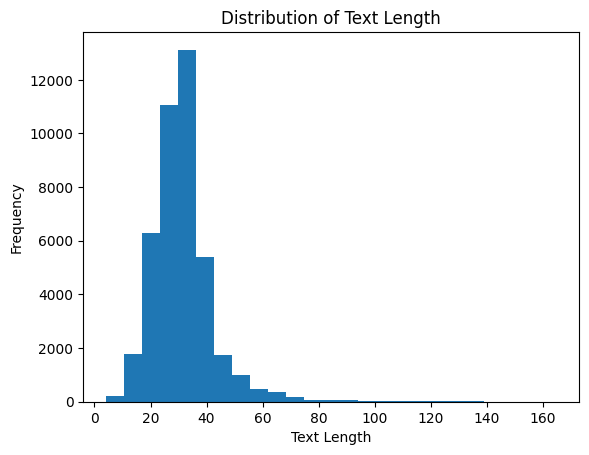

Average Length: 31.54
Median Length: 30.0
Max Length: 165
Min Length: 4
95th Percentile Length: 51.0


In [10]:
#get word counts
text_l = [len(x.split()) for x in x_train]

#plot the distribution
plt.hist(text_l, bins=25)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.show()

#print word count stats
print('Average Length:', round(np.mean(text_l),2))
print('Median Length:', np.median(text_l))
print('Max Length:', np.max(text_l))
print('Min Length:', np.min(text_l))
print('95th Percentile Length:', np.percentile(text_l, 95))

The text observations tend to be around 30 words long with a handful of longer observations. Our longest text observation is 165 words, with most words falling below 100, which means that our output_sequence_length does not need to exceed 100 and, in fact, could be around 45 and still cover 95% of the dataset. Next, let's see if there is any difference when exploring the distributions for each class.

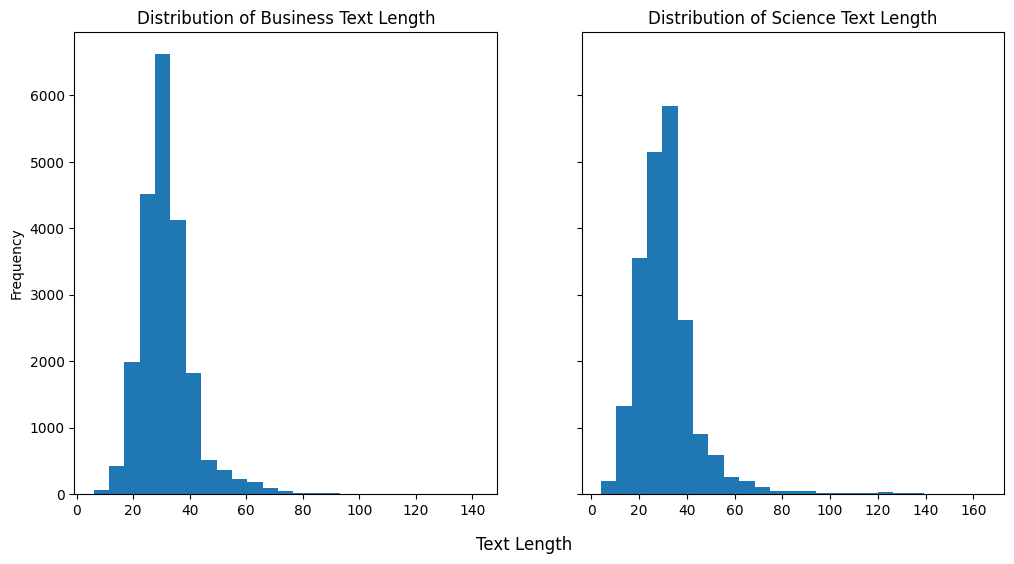

Business Average Length: 31.68
Business Median Length: 31.0
Business Max Length: 142
Business Min Length: 6


Science Average Length: 31.39
Science Median Length: 30.0
Science Max Length: 165
Science Min Length: 4


In [11]:
#get the text for each class
bus_text = x_train[y_train==0]
sci_text = x_train[y_train==1]

#get word counts
bus_text_l = [len(b.split()) for b in bus_text]
sci_text_l = [len(s.split()) for s in sci_text]

#plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes[0].hist(bus_text_l, bins=25)
axes[0].set_title('Distribution of Business Text Length')
axes[0].set_ylabel('Frequency')
axes[1].hist(sci_text_l, bins=25)
axes[1].set_title('Distribution of Science Text Length')
fig.supxlabel('Text Length')

plt.show()

#print word count stats
print('Business Average Length:', round(np.mean(bus_text_l),2))
print('Business Median Length:', np.median(bus_text_l))
print('Business Max Length:', np.max(bus_text_l))
print('Business Min Length:', np.min(bus_text_l))
print('\n')
print('Science Average Length:', round(np.mean(sci_text_l),2))
print('Science Median Length:', np.median(sci_text_l))
print('Science Max Length:', np.max(sci_text_l))
print('Science Min Length:', np.min(sci_text_l))

Both classes tend to have texts of around 30 words in length. The Science texts have a longer right tail, showing that there are a handful of texts that skew longer, however generally, the distribution of the two classes' text lengths are similar

### Commonly Used Words

This section will focus on the commonly used words for each class to help us to better understand the makeup of the text observations for each data type.

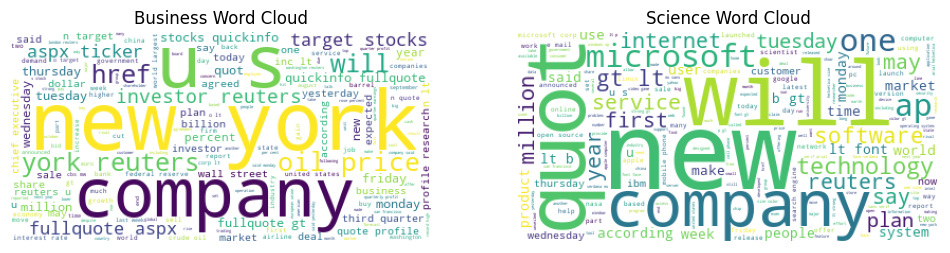

In [12]:
#convert each set of texts to one single string to be used in the wordcloud
bus_text = " ".join(x_train[y_train == 0])
sci_text = " ".join(x_train[y_train == 1])

#use WordCloud function to crate wordcloud for each category
wc_bus = WordCloud(background_color="white").generate(bus_text)
wc_sci = WordCloud(background_color="white").generate(sci_text)

#plot the word clouds
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wc_bus); axes[0].axis("off"); axes[0].set_title("Business Word Cloud")
axes[1].imshow(wc_sci); axes[1].axis("off"); axes[1].set_title("Science Word Cloud")
plt.show()

Based on these word clouds, we can see some differences between the two classes, however there also is some noise, such as words like 'quot' and 'FullQuote' that come from the text settings, as well as words like the city and day of the week that tell us little about the actual topic. To filter these out, we will create word clouds using the TF-IDF values instead of the word frequencies.

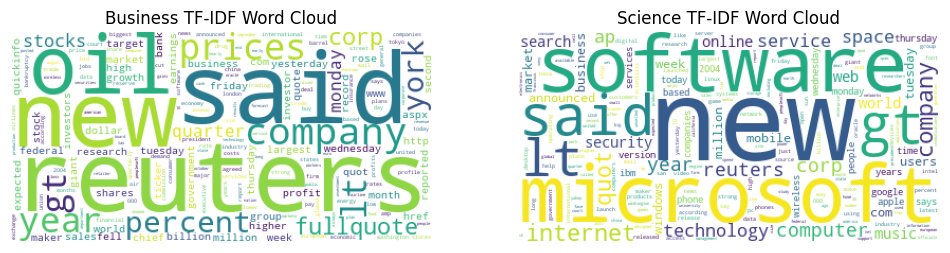

In [13]:
#use the individual documents, not the giant joined string
bus_docs = x_train[y_train == 0]
sci_docs = x_train[y_train == 1]

#create vectorizers with stopwords
vectorizer_b = TfidfVectorizer(stop_words='english')
vectorizer_s = TfidfVectorizer(stop_words='english')

#fit on the class-specific documents
tfidf_vals_b = vectorizer_b.fit_transform(bus_docs)
tfidf_vals_s = vectorizer_s.fit_transform(sci_docs)

#extract vocabulary
words_b = vectorizer_b.get_feature_names_out()
words_s = vectorizer_s.get_feature_names_out()

#average tfidf across all docs in the class
avg_tfidf_b = np.asarray(tfidf_vals_b.mean(axis=0)).flatten()
avg_tfidf_s = np.asarray(tfidf_vals_s.mean(axis=0)).flatten()

#convert to dict for WordCloud
tfidf_b = dict(zip(words_b, avg_tfidf_b))
tfidf_s = dict(zip(words_s, avg_tfidf_s))

#create word clouds
wc_b2 = WordCloud(background_color="white").generate_from_frequencies(tfidf_b)
wc_s2 = WordCloud(background_color="white").generate_from_frequencies(tfidf_s)

#plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wc_b2); axes[0].axis("off"); axes[0].set_title("Business TF-IDF Word Cloud")
axes[1].imshow(wc_s2); axes[1].axis("off"); axes[1].set_title("Science TF-IDF Word Cloud")
plt.show()

### EDA Summary

The EDA section explored the dataset as a whole, as well as split between the two classes. We found that the two classes are balanced and that they tend to have similar distributions of word lengths. This means that we do not need to perform any further data cleaning to ensure there is no minority/majority classes. Additionally, our models should not be skewed from differences in the structure of the text values. 

One interesting take away from the EDA section is that, despite splitting between the texts between Business and Science, actual business names dominate the word frequencies, with Reuters and Microsoft showing up with top TF-IDF values in Business and Science respectively. This may pose some difficulty in our models as text statements may focus on Science/Technology, but have business perspective.

The EDA also helped to provide starting values for our max_tokens and output_sequence_length. Since the corpus is comprised of around 82,000 words, we can initially set our max_tokens to be around 20,000 to account for the majority of frequently used words. Our text lengths are all below 165 words, with 95% of observations falling below 45 words, therefore we can initially set our output_sequence_length to be around 50. These values may change as we test and refine the models, but are helpful baseline values.

Our data exploration also revealed the types of models we should use. Our sequences range from 3 to 163 tokens with the great majority of data falling below the 50 token length, therefore they are not too long for RNN models. They could be a bit short for LSTM and GRU, however our trainig dataset has over 40,000 observations with a corpus of around 50,000 words, which is better handled by LSTM and GRU. Additionally, these text observations can include important information anywhere in the sequence and therefore LSTM and GRU may be helpful for parsing meaning across the entire the text observation. 

## Model the Data

### Baseline Model (Classical ML)

Before we create advance machine learning models, we will first create a classical ML model as our baseline.

In [14]:
#create baseline pipeline with TFIDF and CLF
baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=55))
])

#fit the training data
baseline_clf.fit(x_train, y_train)

#determine validation accuracy 
svm_valid_acc = baseline_clf.score(x_valid, y_valid)
print("Validation Accuracy:", round(svm_valid_acc, 2))

#make predictions on test data using the model
y_test_pred  = baseline_clf.predict(x_test_filtered)
y_test_proba = baseline_clf.predict_proba(x_test_filtered)[:, 1]

#calculate model metrics for test data
clf_acc = accuracy_score(y_test_bin, y_test_pred)
clf_conf_mat = confusion_matrix(y_test_bin, y_test_pred, labels=[0, 1])
tn, fp, fn, tp = clf_conf_mat.ravel()
clf_rec = recall_score(y_test_bin, y_test_pred)
clf_prec = precision_score(y_test_bin, y_test_pred)
clf_fpr = fp / (fp + tn)
clf_fdr = fp / (fp + tp)
clf_auc = roc_auc_score(y_test_bin, y_test_proba)

#print model metrics
print("Testing Accuracy:", round(clf_acc, 2))
print("Confusion matrix:\n", clf_conf_mat)
print("Recall:", round(clf_rec, 2))
print("Precision:", round(clf_prec, 2))
print("FPR:", round(clf_fpr, 2))
print("FDR:", round(clf_fdr, 2))
print("ROC AUC:", round(clf_auc, 2))

Validation Accuracy: 0.91
Testing Accuracy: 0.9
Confusion matrix:
 [[1689  211]
 [ 164 1736]]
Recall: 0.91
Precision: 0.89
FPR: 0.11
FDR: 0.11
ROC AUC: 0.96


We trained a baseline text classification model using a TF-IDF vectorizer (20,000 max features, bigrams included) paired with Logistic Regression.

The baseline model performed extremely well, achieving 91% validation accuracy and 90% test accuracy, with an AUC of 0.96.

The confusion matrix shows balanced performance across classes:
Business (label=0) and Sci/Tech (label=1) are both predicted with high recall (0.91) and precision (0.89).

These results indicate that the vocabulary-level differences between the two news categories are strong and largely linearly separable. As such, TF-IDF + Logistic Regression provides a robust foundation and a challenging baseline for comparison with the deep learning models (Simple RNN, LSTM, GRU).

### Deep Learning Models (RNN/LSTM/GRU)

Now, we will turn to creating deep learning models to compare with the baseline metrics and each other. Since we will be using tensorflow functionality, we will need to first convert the datasets to be usable with tensorflow functions.

In [15]:
#Convert the data to be usable with tensor flow functions
x_train_tf = tf.constant(x_train, dtype=tf.string)
x_valid_tf = tf.constant(x_valid, dtype=tf.string)
x_test_tf  = tf.constant(x_test_filtered, dtype=tf.string)

y_train_tf = tf.constant(y_train, dtype=tf.int32)
y_valid_tf = tf.constant(y_valid, dtype=tf.int32)
y_test_tf  = tf.constant(y_test_bin, dtype=tf.int32)

#Confirming our labels are still between 0 and 1
print("Train labels:", np.unique(y_train_tf.numpy()))
print("Valid labels:", np.unique(y_valid_tf.numpy()))
print("Test labels:",  np.unique(y_test_tf.numpy()))

#Train, validation, and test set sizes
print('Training Sets:', x_train_tf.shape, y_train_tf.shape)
print('Validation Sets:', x_valid_tf.shape, y_valid_tf.shape)
print('Test Sets:', x_test_tf.shape, y_test_tf.shape)

Train labels: [0 1]
Valid labels: [0 1]
Test labels: [0 1]
Training Sets: (42000,) (42000,)
Validation Sets: (18000,) (18000,)
Test Sets: (3800,) (3800,)


In [16]:
#set parameters based on EDA
max_tokens = 20000
max_sequence_length = 50

#create vectorized layer to be used in models 
vectorized = TextVectorization(
    max_tokens=max_tokens,  
    output_sequence_length=max_sequence_length
)

#adapt to the training data
vectorized.adapt(x_train_tf)

#### Simple RNN Model

We will start with a simple RNN model.

In [17]:
#set parameters
embedding_dims = 32 
K = 16

#create RNN model
model_rnn = Sequential()
model_rnn.add(Input(shape=(1,), dtype='string'))
model_rnn.add(vectorized)
model_rnn.add(Embedding(max_tokens + 1, embedding_dims))
model_rnn.add(SimpleRNN(K, return_sequences=False))
model_rnn.add(Dense(50, activation='relu',
                kernel_regularizer=keras.regularizers.l1(.001)))
model_rnn.add(Dropout(.5))
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 32)         │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │           850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641,717 (2.45 MB)

 Trainable params: 641,717 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#compile model 
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

model_rnn_history = model_rnn.fit(x_train_tf, y_train_tf, epochs=50, batch_size=1024, 
          validation_data=(x_valid_tf, y_valid_tf),
          callbacks=[early_stopping])

Epoch 1/50


2025-12-07 13:42:36.888276: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-07 13:42:36.888583: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5874 - auc: 0.6279 - loss: 0.7736 - precision: 0.5897 - recall: 0.5750 - val_accuracy: 0.6632 - val_auc: 0.7121 - val_loss: 0.7177 - val_precision: 0.6416 - val_recall: 0.7394
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7285 - auc: 0.7870 - loss: 0.6472 - precision: 0.7104 - recall: 0.7717 - val_accuracy: 0.6990 - val_auc: 0.7642 - val_loss: 0.6645 - val_precision: 0.6796 - val_recall: 0.7530
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7990 - auc: 0.8643 - loss: 0.5351 - precision: 0.7840 - recall: 0.8254 - val_accuracy: 0.7104 - val_auc: 0.7802 - val_loss: 0.6565 - val_precision: 0.6907 - val_recall: 0.7621
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8428 - auc: 0.9084 - loss: 0.4484 - precision: 0.8312 - recall: 0.8604 - val_accuracy: 0.7271 - val_auc: 0.8000 - val_loss: 0.6501 - val_precision: 0.7148 - val_recall: 0.7557
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/s

In [19]:
#get test metrics
rnn_loss, rnn_acc, rnn_prec, rnn_rec, rnn_auc = model_rnn.evaluate(x_test_tf, y_test_tf, verbose=0)
print("RNN Metrics")
print("Loss:", rnn_loss)
print("Accuracy:", rnn_acc)
print("Precision:", rnn_prec)
print("Recall:", rnn_rec)
print("AUC:", rnn_auc)

RNN Metrics
Loss: 0.6586692929267883
Accuracy: 0.7221052646636963
Precision: 0.713131308555603
Recall: 0.7431579232215881
AUC: 0.7979099750518799


2025-12-07 13:42:47.654385: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-07 13:42:47.654627: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

#### LSTM Model

In [20]:
embedding_dims = 8
K = 16 

model_lstm = Sequential()
model_lstm.add(Input(shape=(1,), dtype='string'))
model_lstm.add(vectorized)
model_lstm.add(Embedding(max_tokens + 1, embedding_dims))
model_lstm.add(LSTM(K, return_sequences=False))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(.5))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 50, 8)          │       160,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,761 (635.79 KB)

 Trainable params: 162,761 (635.79 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

early_stopping_lstm = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

model_lstm_history  = model_lstm.fit(x_train_tf, y_train_tf, epochs=50, batch_size=1050, 
          validation_data=(x_valid_tf, y_valid_tf),
          callbacks=[early_stopping])

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5077 - auc_1: 0.5127 - loss: 0.6926 - precision_1: 0.5091 - recall_1: 0.4325 - val_accuracy: 0.5446 - val_auc_1: 0.5547 - val_loss: 0.6905 - val_precision_1: 0.6253 - val_recall_1: 0.2227
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7527 - auc_1: 0.8376 - loss: 0.5328 - precision_1: 0.7390 - recall_1: 0.7815 - val_accuracy: 0.8812 - val_auc_1: 0.9477 - val_loss: 0.3319 - val_precision_1: 0.8931 - val_recall_1: 0.8661
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9072 - auc_1: 0.9496 - loss: 0.2726 - precision_1: 0.9011 - recall_1: 0.9148 - val_accuracy: 0.9041 - val_auc_1: 0.9615 - val_loss: 0.2532 - val_precision_1: 0.8978 - val_recall_1: 0.9119
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9342 - auc_1: 0.9697 - loss: 0.2029 - precision_1: 0.9264 - recall_1: 0.9434 - val_accuracy: 0.9085 - val_auc_1: 0.9655 - val_loss: 0.2382 - val_precision_1: 0.8940 - val_recal

In [22]:
#get test metrics
lstm_loss, lstm_acc, lstm_prec, lstm_rec, lstm_auc = model_lstm.evaluate(x_test_tf, y_test_tf, verbose=0)
print("LSTM Metrics")
print("Loss:", lstm_loss)
print("Accuracy:", lstm_acc)
print("Precision:", lstm_prec)
print("Recall:", lstm_rec)
print("AUC:", lstm_auc)

LSTM Metrics
Loss: 0.25590619444847107
Accuracy: 0.9049999713897705
Precision: 0.906497597694397
Recall: 0.9031578898429871
AUC: 0.9627248048782349


2025-12-07 13:43:07.728405: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-07 13:43:07.728653: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

#### GRU Model

In [23]:
embedding_dims = 32 

model_gru = Sequential()
model_gru.add(Input(shape=(1,), dtype='string'))
model_gru.add(vectorized)
model_gru.add(Embedding(max_tokens + 1, embedding_dims))
model_gru.add(GRU(32, return_sequences=False)) # K
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dropout(.5))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.summary()


model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

history = model_gru.fit(x_train_tf, y_train_tf, epochs=30, batch_size=512, 
          validation_data=(x_valid_tf, y_valid_tf),
          callbacks=[early_stopping])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 50, 32)         │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,545 (2.47 MB)

 Trainable params: 648,545 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5058 - auc_2: 0.5071 - loss: 0.6929 - precision_2: 0.5060 - recall_2: 0.5677

2025-12-07 13:43:13.319981: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-07 13:43:13.320235: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.5084 - auc_2: 0.5107 - loss: 0.6923 - precision_2: 0.5095 - recall_2: 0.4467 - val_accuracy: 0.5146 - val_auc_2: 0.5148 - val_loss: 0.6896 - val_precision_2: 0.6195 - val_recall_2: 0.0754
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7306 - auc_2: 0.8258 - loss: 0.5054 - precision_2: 0.7717 - recall_2: 0.6548 - val_accuracy: 0.8957 - val_auc_2: 0.9582 - val_loss: 0.2746 - val_precision_2: 0.8628 - val_recall_2: 0.9409
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9207 - auc_2: 0.9663 - loss: 0.2231 - precision_2: 0.9127 - recall_2: 0.9304 - val_accuracy: 0.9073 - val_auc_2: 0.9657 - val_loss: 0.2436 - val_precision_2: 0.9155 - val_recall_2: 0.8973
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9408 - auc_2: 0.9777 - loss: 0.1755 - precision_2: 0.9324 - recall_2: 0.9506 - val_accuracy: 0.8918 - val_auc_2: 0.9663 - val_loss: 0.2897 - val_precision_2: 0.8395 - val_recall_2: 0.9689

In [24]:
#get test metrics
gru_loss, gru_acc, gru_prec, gru_rec, gru_auc = model_gru.evaluate(x_test_tf, y_test_tf, verbose=0)
print("GRU Metrics")
print("Loss:", gru_loss)
print("Accuracy:", gru_acc)
print("Precision:", gru_prec)
print("Recall:", gru_rec)
print("AUC:", gru_auc)

2025-12-07 13:43:32.764283: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-07 13:43:32.764547: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

GRU Metrics
Loss: 0.688676655292511
Accuracy: 0.5184210538864136
Precision: 0.6576576828956604
Recall: 0.07684210687875748
AUC: 0.5194860100746155


## Model Comparison & Discussion

Now that we have run and optimized our three models, let's compare the results.

In [25]:
#compare metrics across the four models
results = [
    ("SVM TF-IDF", clf_acc, clf_prec, clf_rec, clf_auc),
    ("SimpleRNN", rnn_acc, rnn_prec, rnn_rec, rnn_auc, rnn_loss),
    ("LSTM", lstm_acc, lstm_prec, lstm_rec, lstm_auc, lstm_loss),
    ("GRU", gru_acc, gru_prec, gru_rec, gru_auc, gru_loss),
]

results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "AUC", "Loss"]
)

results_df

,Model,Accuracy,Precision,Recall,AUC,Loss
0,SVM TF-IDF,0.901316,0.891628,0.913684,0.959080,NaN
1,SimpleRNN,0.722105,0.713131,0.743158,0.797910,0.658669
2,LSTM,0.905000,0.906498,0.903158,0.962725,0.255906
3,GRU,0.518421,0.657658,0.076842,0.519486,0.688677


Our simplest, baseline model and the GRU model performed best on all relevant metrics. Though Loss does not make sense for the baseline metric, we can evaluate the other three models on Loss and see that all three have generally high loss values, with LSTM the highest. The GRU model outperformed the baseline model on Accuracy, Recall and AUC, however the scores are extremely close. Additionally, the baseline model is significantly simpler than the GRU model, taking much shorter to train and generally is easier to understand. Therefore our baseline model is likely the best, with its high Accuracy, Precision, Recall and AUC as well as the deep learning models' high loss and the simplicity and speed of training, the simple, baseline model is likely the best for this situation.

This make sense in the context of the problem. Firstly, we noted during EDA that our text observations are relatively short and therefore more complex models like LSTM and GRU may not be best fit for it. Additionally, this dataset uses article descriptions to classify the article subject. Unlike text data like casual conversation or written reviews, writers of article descriptions are likely more thoughtful about the descriptors used and have fewer cases of double negatives changing the meaning of the whole text or words at the end of the observation changing the meaning of earlier words. Therefore, we will move forward with presenting and using the simple, baseline model for our classification as it is accurate, fast, and simple.